<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/WiggleGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Wiggle dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander/
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
----------------------------------------------------------
ALL MODELS: 
KISS-GP For 1D-4D data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

KISS-GP For higher dimensional data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP_NDim(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

 Variational GP:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.Const

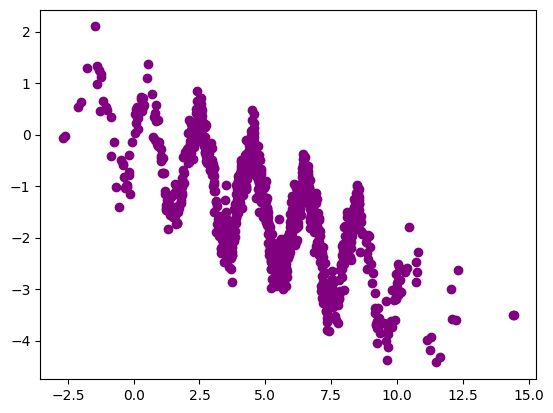

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch > \dev\null # Suppress prints
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook
%run "datasets/wiggle.ipynb" # Run the wiggle notebook which is in the same folder(Wiggle dataset)


# Training Data from wiggle

In [3]:
x_wiggle, y_wiggle = x_wiggle, samples # x, samples are defined in ../datasets/wiggle.ipynb

x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = train_test_split(x_wiggle, y_wiggle, test_size=0.2, random_state=666)
# Transform into tensors
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = (
torch.from_numpy(x_train_wiggle), torch.from_numpy(x_test_wiggle),
torch.from_numpy(y_train_wiggle), torch.from_numpy(y_test_wiggle))

# Define the KISS-GP Model

In [4]:
KISSGP_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_wiggle = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_wiggle = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_wiggle = KISSGP(x_train_wiggle,
                             y_train_wiggle,
                             KISSGP_likelihood_wiggle,
                             KISSGP_mean_wiggle,
                             KISSGP_kernel_wiggle) # KISSGP defined in utils/Models.ipynb

# Train the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


43.55166149139404


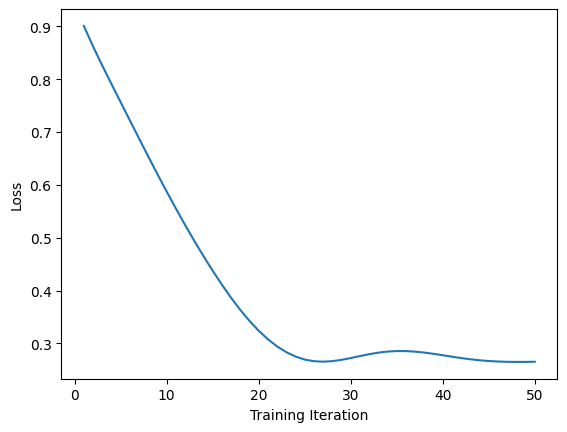

In [5]:
train_time_KISSGP_wiggle = train(KISSGP_model_wiggle,
                                 KISSGP_likelihood_wiggle,
                                 x_train_wiggle, y_train_wiggle,
                                 training_iter= 50) # train is defined in utils/functions.ipynb
print(train_time_KISSGP_wiggle)



# Plot KISS-GP Model

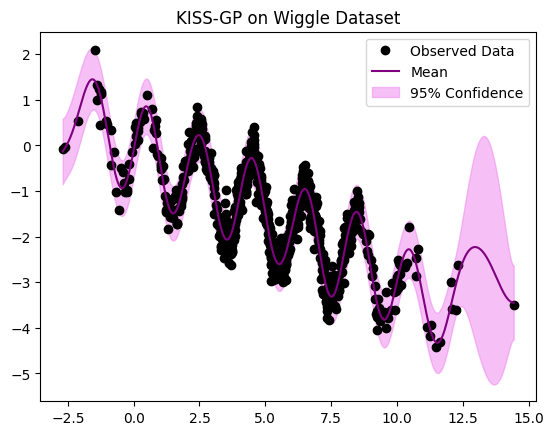

In [6]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_wiggle, y_train_wiggle, KISSGP_model_wiggle, KISSGP_likelihood_wiggle, "KISS-GP on Wiggle Dataset")

# Predict and Evaluate KISS-GP Model

In [7]:
# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle,
                                      KISSGP_likelihood_wiggle,
                                      x_test_wiggle) # predict is defined in utils/functions.ipynb

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle, KISSGP_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_wiggle, NLPD_KISSGP_wiggle, PICP_KISSGP_wiggle, MPIW_KISSGP_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_KISSGP_wiggle.mean,
      predictions_KISSGP_wiggle.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_wiggle)
  print("NLPD KISS-GP: ",NLPD_KISSGP_wiggle)
  print("PICP KISS-GP: ",PICP_KISSGP_wiggle)
  print("MPIW KISS-GP: ",MPIW_KISSGP_wiggle)
  print("Time KISS-GP: ", train_time_KISSGP_wiggle)

RMSE KISS-GP:  0.31636469071760515
NLPD KISS-GP:  tensor(0.2739, dtype=torch.float64)
PICP KISS-GP:  0.935
MPIW KISS-GP:  1.1855332076209302
Time KISS-GP:  43.55166149139404


# Variational Model

In [8]:
variational_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_wiggle = gpytorch.means.ConstantMean()
variational_kernel_wiggle = gpytorch.kernels.RBFKernel()
n_inducing_points = 150
inducing_points = x_train_wiggle[torch.randperm(x_train_wiggle.size(0))[:n_inducing_points]]
variational_model_wiggle = variationalGP(variational_likelihood_wiggle, variational_mean_wiggle, variational_kernel_wiggle, inducing_points) # .variationalGP defined in utils/models.ipynb
variational_model_wiggle = variational_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Variational Model

Training Time:  3.551689624786377


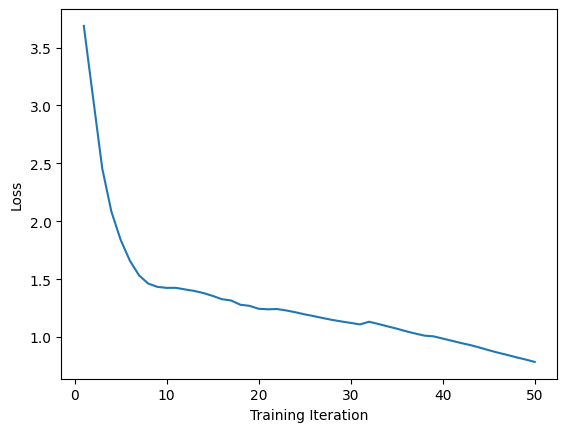

In [9]:
train_time_variational_wiggle = train_ELBO(variational_model_wiggle, variational_likelihood_wiggle, x_train_wiggle, y_train_wiggle, training_iter= 50) # train is defined in utils/functions.ipynb
print("Training Time: ",train_time_variational_wiggle)



# Plot Variational Model

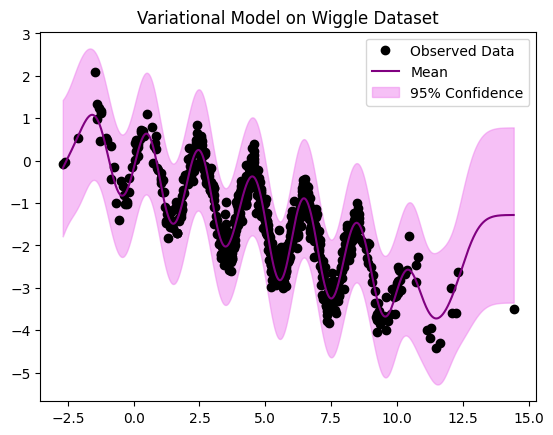

In [10]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_wiggle, y_train_wiggle, variational_model_wiggle, variational_likelihood_wiggle, "Variational Model on Wiggle Dataset")

# Predict and Evaluate Variational Model

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_wiggle = predict(variational_model_wiggle, variational_likelihood_wiggle, x_test_wiggle)

  RMSE_variational_wiggle, NLPD_variational_wiggle, PICP_variational_wiggle, MPIW_variational_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_variational_wiggle.mean,
      predictions_variational_wiggle.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_wiggle)
  print("NLPD variational Model: ",NLPD_variational_wiggle)
  print("PICP variational Model: ",PICP_variational_wiggle)
  print("MPIW variational Model: ",MPIW_variational_wiggle)
  print("Time variational Model: ", train_time_variational_wiggle)

RMSE variational Model:  0.36768827469946397
NLPD variational Model:  tensor(0.7052, dtype=torch.float64)
PICP variational Model:  0.995
MPIW variational Model:  2.811702429561726
Time variational Model:  3.551689624786377


# State Space Model Optimized

In [12]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_wiggle)
all_points = jnp.concatenate([x_train_wiggle.numpy(), x_test_wiggle.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs_wiggle = all_points[temporal_order]
ss_ys_wiggle = jnp.concatenate([y_train_wiggle.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]

# Compute the equivalent SS model
t0 = min(x_train_wiggle).numpy().item()
dts_wiggle = jnp.diff(ss_xs_wiggle, prepend=t0)

In [13]:
# Calculate ell and sigma
opt_ell_wiggle, opt_sigma_wiggle, train_time_SSOP_wiggle = train_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, ell=1, sigma=1)

In [14]:
mfs, vfs, mps, vps, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, opt_ell_wiggle, opt_sigma_wiggle, m0=0, v0=1)
mss, vss = kalmanSmoothing(opt_ell_wiggle, dts_wiggle, mfs, vfs, mps, vps)
ssop_posterior_mean_wiggle = mss[jnp.isnan(ss_ys_wiggle)]
ssop_posterior_var_wiggle = vss[jnp.isnan(ss_ys_wiggle)]

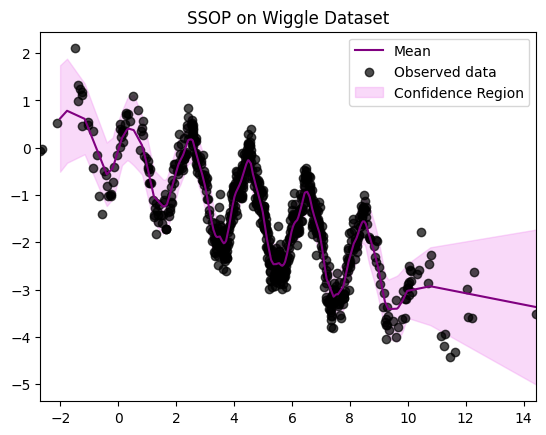

In [15]:
# Plot SSOP
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, ssop_posterior_mean_wiggle, ssop_posterior_var_wiggle, title= "SSOP on Wiggle Dataset")

# Evaluate SSOP

In [17]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Order y_test, x_test
  temporal_order = jnp.argsort(x_test_wiggle.numpy())
  y_test_temporal_order = y_test_wiggle.numpy()[temporal_order]
  x_test_temporal_order = x_test_wiggle.numpy()[temporal_order]

  RMSE_SSOP_wiggle, NLPD_SSOP_wiggle, PICP_SSOP_wiggle, MPIW_SSOP_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(ssop_posterior_mean_wiggle)),
      torch.tensor(np.array(ssop_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSOP Model: ",RMSE_SSOP_wiggle)
  print("NLPD SSOP Model: ",NLPD_SSOP_wiggle)
  print("PICP SSOP Model: ",PICP_SSOP_wiggle)
  print("MPIW SSOP Model: ",MPIW_SSOP_wiggle)
  print("Time SSOP Model: ", train_time_SSOP_wiggle)

RMSE SSOP Model:  0.3226161538985354
NLPD SSOP Model:  tensor(0.3526, dtype=torch.float64)
PICP SSOP Model:  0.855
MPIW SSOP Model:  0.9808548
Time SSOP Model:  1.496593952178955


SS with PyTorch

In [18]:
# Train with pytorch instead

# Calculate ell and sigma
opt_ell_wiggle_torch, opt_sigma_wiggle_torch, train_time_SSPY_wiggle = train_SSGP_torch(x_train_wiggle,
                                                                                            y_train_wiggle,
                                                                                            x_test_wiggle,
                                                                                            ell=1,
                                                                                            sigma=1)
# Convert them to numpy arrays
# Assume tensor is on GPU
opt_ell_wiggle_pytorch = opt_ell_wiggle_torch.to('cpu')
opt_sigma_wiggle_pytorch = opt_sigma_wiggle_torch.to('cpu')

opt_ell_wiggle_numpy = opt_ell_wiggle_pytorch.numpy()
opt_sigma_wiggle_numpy = opt_sigma_wiggle_pytorch.numpy()
# Calculate mean and variance
mfs_torch, vfs_torch, mps_torch, vps_torch, _ = kalmanFilter(ss_ys_wiggle,
                                                             dts_wiggle,
                                                             opt_ell_wiggle_numpy,
                                                             opt_sigma_wiggle_numpy,
                                                             m0=0, v0=1)
mss_torch, vss_torch = kalmanSmoothing(opt_ell_wiggle_numpy, dts_wiggle, mfs_torch, vfs_torch, mps_torch, vps_torch)
sspy_posterior_mean_wiggle = mss[jnp.isnan(ss_ys_wiggle)]
sspy_posterior_var_wiggle = vss[jnp.isnan(ss_ys_wiggle)]



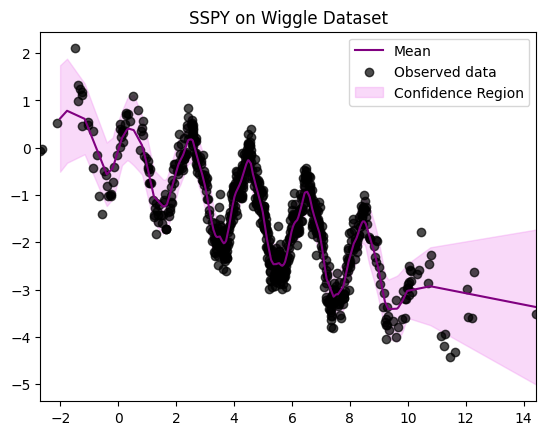

In [20]:
# Plot SSPY
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, sspy_posterior_mean_wiggle, sspy_posterior_var_wiggle, title= "SSPY on Wiggle Dataset")

In [21]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  RMSE_SSPY_wiggle, NLPD_SSPY_wiggle, PICP_SSPY_wiggle, MPIW_SSPY_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sspy_posterior_mean_wiggle)),
      torch.tensor(np.array(sspy_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSPY Model: ",RMSE_SSPY_wiggle)
  print("NLPD SSPY Model: ",NLPD_SSPY_wiggle)
  print("PICP SSPY Model: ",PICP_SSPY_wiggle)
  print("MPIW SSPY Model: ",MPIW_SSPY_wiggle)
  print("Time SSPY Model: ", train_time_SSPY_wiggle)

RMSE SSPY Model:  0.3226161538985354
NLPD SSPY Model:  tensor(0.3526, dtype=torch.float64)
PICP SSPY Model:  0.855
MPIW SSPY Model:  0.9808548
Time SSPY Model:  1.3319001197814941


# State Space Model, without optimizer

In [22]:
# Pick hyperparameters on your own:
ell = 3
sigma = 1

start_time = time.time()
mfs2, vfs2, mps2, vps2, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, ell, sigma, m0=0, v0=1)
mss2, vss2 = kalmanSmoothing(ell, dts_wiggle, mfs2, vfs2, mps2, vps2)
sswo_posterior_mean_wiggle = mss2[jnp.isnan(ss_ys_wiggle)]
sswo_posterior_var_wiggle = vss2[jnp.isnan(ss_ys_wiggle)]
end_time = time.time()
train_time_SSWO_wiggle = end_time-start_time

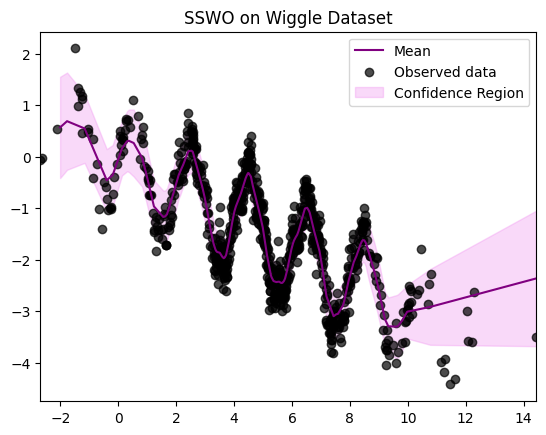

In [23]:
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, sswo_posterior_mean_wiggle, sswo_posterior_var_wiggle, title= "SSWO on Wiggle Dataset")

# Evaluate SSWO

In [24]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():

  RMSE_SSWO_wiggle, NLPD_SSWO_wiggle, PICP_SSWO_wiggle, MPIW_SSWO_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sswo_posterior_mean_wiggle)),
      torch.tensor(np.array(sswo_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSWO Model: ",RMSE_SSWO_wiggle)
  print("NLPD SSWO Model: ",NLPD_SSWO_wiggle)
  print("PICP SSWO Model: ",PICP_SSWO_wiggle)
  print("MPIW SSWO Model: ",MPIW_SSWO_wiggle)
  print("Time SSWO Model: ", train_time_SSWO_wiggle)

RMSE SSWO Model:  0.354190315409514
NLPD SSWO Model:  tensor(0.5778, dtype=torch.float64)
PICP SSWO Model:  0.785
MPIW SSWO Model:  0.87672687
Time SSWO Model:  0.49442124366760254


# Inducing Points Model

In [25]:
inducing_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_wiggle = gpytorch.means.ConstantMean() # Mean
inducing_kernel_wiggle = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_wiggle.size(0))
# Select N random rows
inducing_points_amount = 50 # Choose how many inducing points
inducing_points = x_train_wiggle[indices][:inducing_points_amount]
inducing_model_wiggle = inducingGP(x_train_wiggle,
                                 y_train_wiggle,
                                 inducing_likelihood_wiggle,
                                 inducing_mean_wiggle,
                                 inducing_kernel_wiggle,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

# Train Inducing Points Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


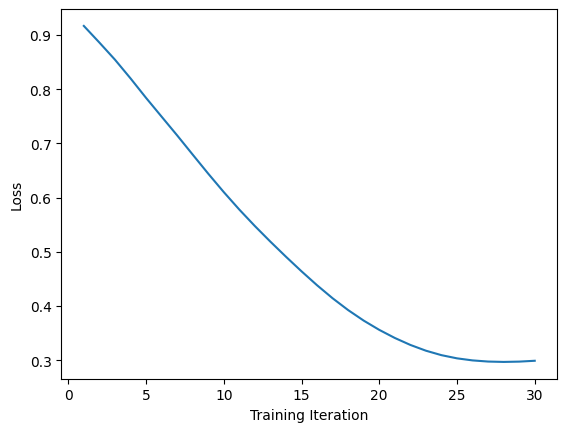

In [26]:
train_time_inducing_wiggle = train(inducing_model_wiggle,
                          inducing_likelihood_wiggle,
                          x_train_wiggle,
                          y_train_wiggle,
                          training_iter= 30) # train is defined in utils/functions.ipynb

# Plot Inducing Points Model

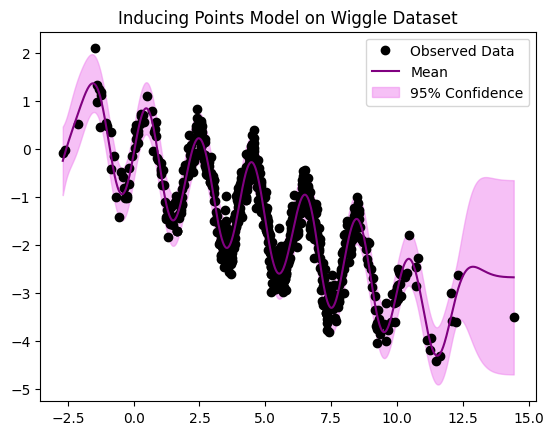

In [27]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_wiggle, y_train_wiggle, inducing_model_wiggle, inducing_likelihood_wiggle, "Inducing Points Model on Wiggle Dataset")

# Predict and Evaluate Inducing Points Model

In [28]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_wiggle = predict(inducing_model_wiggle, inducing_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_inducing_wiggle, NLPD_inducing_wiggle, PICP_inducing_wiggle, MPIW_inducing_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_inducing_wiggle.mean,
      predictions_inducing_wiggle.variance)# error_metrics defined in utils/functions.ipynb



  print("RMSE inducing: ",RMSE_inducing_wiggle)
  print("NLPD inducing: ",NLPD_inducing_wiggle)
  print("PICP inducing: ",PICP_inducing_wiggle)
  print("MPIW inducing: ",MPIW_inducing_wiggle)
  print("Time inducing: ", train_time_inducing_wiggle)

RMSE inducing:  0.32199758747482676
NLPD inducing:  tensor(0.3094, dtype=torch.float64)
PICP inducing:  0.915
MPIW inducing:  1.0708925365944768
Time inducing:  0.4373483657836914


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


# Display Results

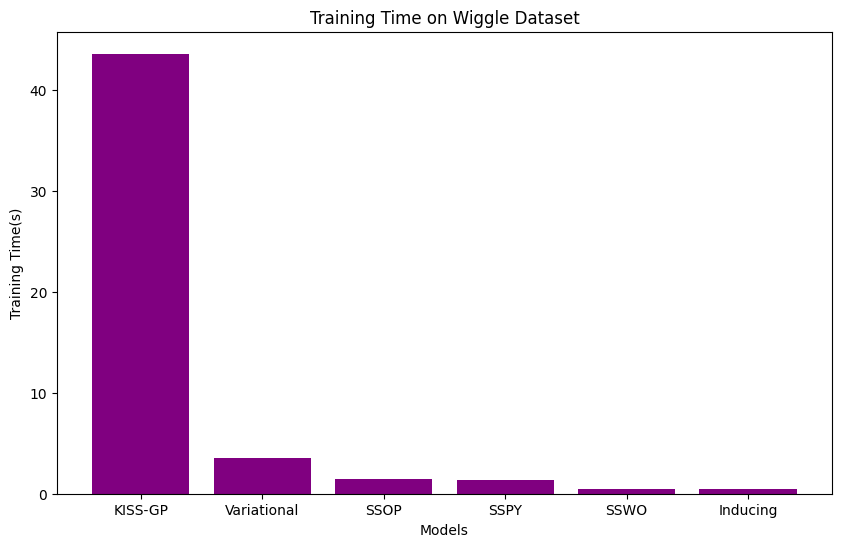

In [29]:
# Training times
models = ["KISS-GP", "Variational", "SSOP", "SSPY", "SSWO", "Inducing"]
times_wiggle = [train_time_KISSGP_wiggle, train_time_variational_wiggle, train_time_SSOP_wiggle, train_time_SSPY_wiggle, train_time_SSWO_wiggle, train_time_inducing_wiggle]
plot_bar(models, times_wiggle, "Training Time on Wiggle Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

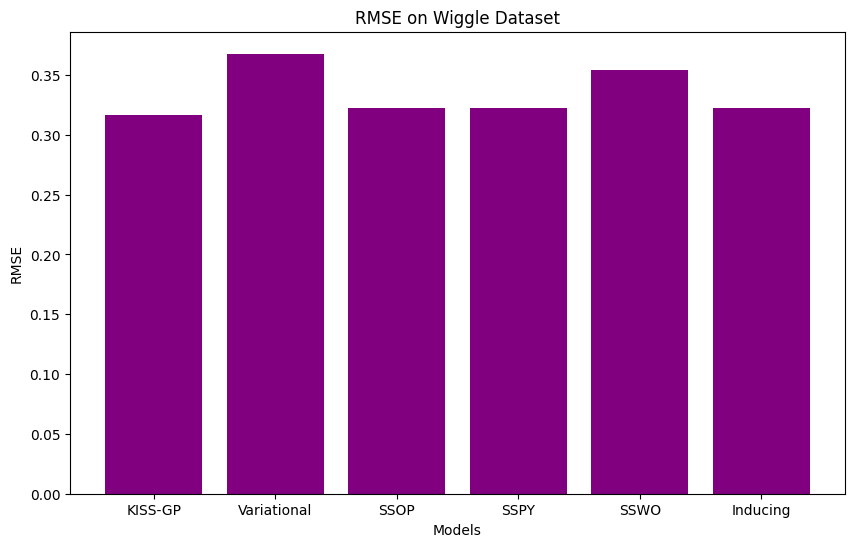

In [30]:
# RMSE
models = ["KISS-GP", "Variational", "SSOP", "SSPY", "SSWO", "Inducing"]
RMSE_wiggle = [RMSE_KISSGP_wiggle, RMSE_variational_wiggle, RMSE_SSOP_wiggle, RMSE_SSPY_wiggle, RMSE_SSWO_wiggle, RMSE_inducing_wiggle]
plot_bar(models, RMSE_wiggle, "RMSE on Wiggle Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

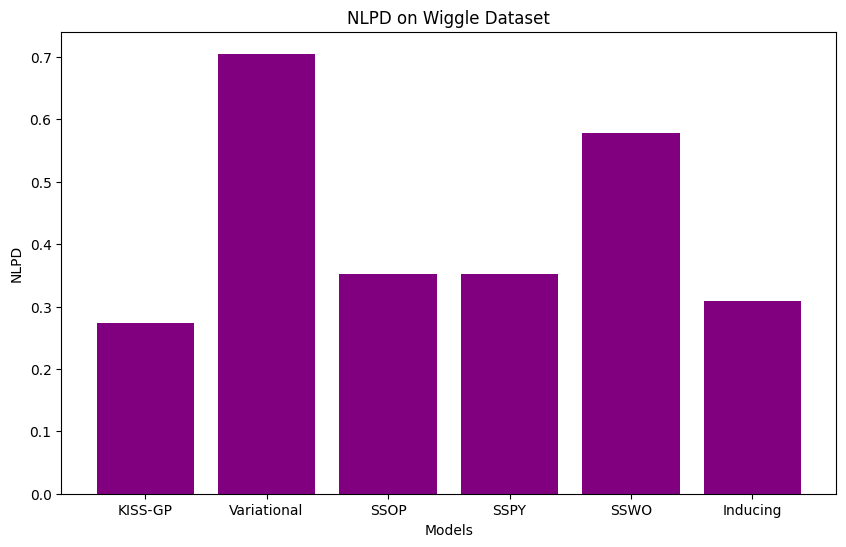

In [31]:
# NLPD
models = ["KISS-GP", "Variational", "SSOP", "SSPY", "SSWO", "Inducing"]
NLPD_wiggle = [NLPD_KISSGP_wiggle, NLPD_variational_wiggle, NLPD_SSOP_wiggle, NLPD_SSPY_wiggle, NLPD_SSWO_wiggle, NLPD_inducing_wiggle]
plot_bar(models, NLPD_wiggle, "NLPD on Wiggle Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

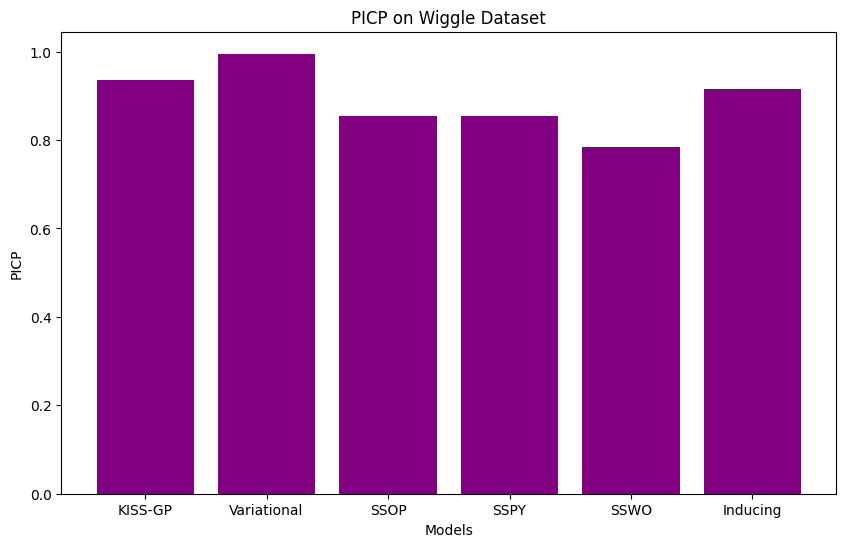

In [32]:
# PICP
models = ["KISS-GP", "Variational", "SSOP", "SSPY", "SSWO", "Inducing"]
PICP_wiggle = [PICP_KISSGP_wiggle, PICP_variational_wiggle, PICP_SSOP_wiggle, PICP_SSPY_wiggle, PICP_SSWO_wiggle, PICP_inducing_wiggle]
plot_bar(models, PICP_wiggle, "PICP on Wiggle Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb


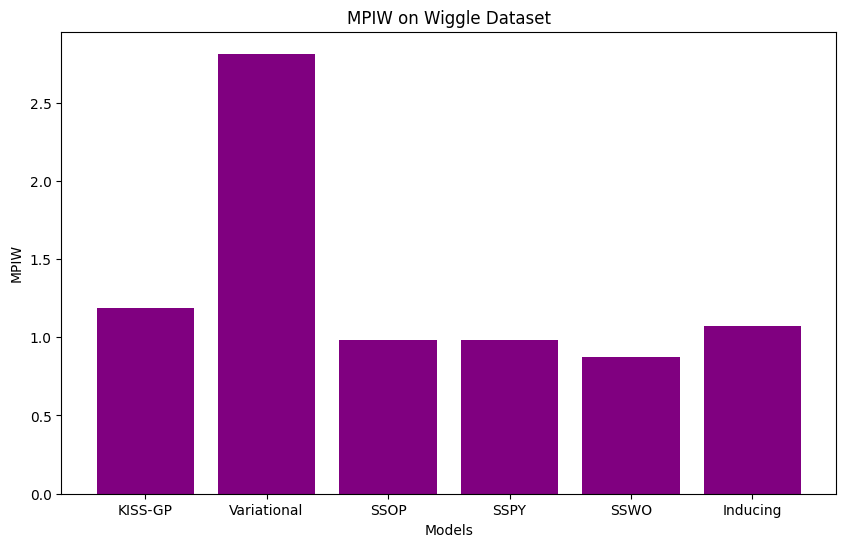

In [33]:
# MPIW
models = ["KISS-GP", "Variational", "SSOP", "SSPY", "SSWO", "Inducing"]
MPIW_wiggle = [MPIW_KISSGP_wiggle, MPIW_variational_wiggle, MPIW_SSOP_wiggle, MPIW_SSPY_wiggle, MPIW_SSWO_wiggle, MPIW_inducing_wiggle]
plot_bar(models, MPIW_wiggle, "MPIW on Wiggle Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb